In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras as ks
import seaborn as sns
from PIL import Image
%matplotlib inline

In [19]:
featurespath = '../Data/Features/UnusedFeatures/'
surv_path = '../Data/Survey/CleanedResults.csv'
object_path = '../Data/Features/Object_features.csv'

# Image processing

Recover pixel threshold data and object data

In [20]:
contrast_level = 40
thresSup = 130
thresInf = 120
thresWhite = 235

# Read pixel color threshold
file_green = 'df_green_pix_inf' + str(thresInf) + '_sup' + str(thresSup) + '_contrast_' + str(contrast_level) + '.csv'
file_blue = 'df_blue_pix_inf' + str(thresInf) + '_sup' + str(thresSup) + '_contrast_' + str(contrast_level) + '.csv'
file_white= 'df_white_pix_thres' + str(thresWhite) + '_contrast_' + str(contrast_level) + '.csv'

df_green_pix = pd.read_csv(featurespath + file_green)
df_blue_pix = pd.read_csv(featurespath + file_blue)
df_white_pix = pd.read_csv(featurespath + file_white)

# Read object features
obj = pd.read_csv(object_path)

# Survey Answers and Image Ranking

In [21]:
surv = pd.read_csv(surv_path)
surv = surv.iloc[: , 1:] #Just to remove this Unnamed 0 column
surv.describe()

,Age,Percentage of lifetime in a city,Image1 ID,Image2 ID,Winner,Person ID
count,14254.000000,14254.000000,14254.000000,14254.000000,14254.000000,1.425400e+04
mean,32.559632,0.536940,227.012418,230.548688,230.618353,2.395758e+07
std,20.909320,0.412010,132.377288,131.419003,131.196153,2.509833e+07
min,12.000000,0.000000,0.000000,0.000000,0.000000,2.160600e+04
25%,20.000000,0.000000,112.000000,117.000000,111.000000,2.299160e+06
50%,22.000000,0.754967,228.000000,233.000000,235.000000,2.013920e+07
75%,30.000000,0.929360,341.000000,344.000000,338.750000,2.443626e+07
max,96.000000,1.000000,457.000000,457.000000,457.000000,9.617434e+07


### Build Ranking for images

In [22]:
win = pd.DataFrame(surv['Winner'].value_counts())
win.sort_index(ascending=True, inplace=True)

In [23]:
im1 = pd.DataFrame(surv['Image1 ID'].value_counts())
im1.sort_index(ascending=True, inplace=True)

In [24]:
im2 = pd.DataFrame(surv['Image2 ID'].value_counts())
im2.sort_index(ascending=True, inplace=True)

In [25]:
occur = pd.DataFrame(im1.values+im2.values, columns=['Image occurence'])

In [26]:
contest = pd.concat([occur, win],axis=1)

In [27]:
contest['Win ratio'] = contest['Winner'] / contest['Image occurence']

In [28]:
contest.reset_index(inplace=True)
contest.fillna(0.0, inplace=True)

In [29]:
contest.drop(['Image occurence','Winner'], axis=1, inplace=True)

In [30]:
# contest.rename(columns={'index':'Image number'})

In [31]:
df_model = pd.merge(contest, obj, left_on='index', right_on='Image number', how='outer')

In [32]:
df_model.drop(['index'], axis=1, inplace=True)

In [33]:
df_model.describe()

,Win ratio,Image number,Reliability,Size of box
count,1956.000000,1956.000000,1910.000000,1910.000000
mean,0.481547,236.456544,87.853907,5534.005236
std,0.189512,130.307901,12.191534,10868.136503
min,0.015873,0.000000,60.056555,42.000000
25%,0.328767,130.000000,78.582206,272.000000
50%,0.483333,231.000000,92.697489,1064.000000
75%,0.632941,358.000000,98.486102,4812.500000
max,0.916667,457.000000,99.981439,105245.000000


# Feature engineering

Do feature engineering, feature expansion, standardize numerical data, one_hot_encode vehicles and other objects, etc.

### Building the dataframe

In [34]:
pd.set_option('display.max_rows', None)

In [35]:
# Do objects have a negative impact (car, truck, traffic light, etc.)

In [36]:
df_model['Object'].value_counts()

car              1660
person            118
motorbike          48
truck              31
traffic light      20
bus                15
fire hydrant        6
bicycle             4
pottedplant         3
handbag             3
bird                1
stop sign           1
Name: Object, dtype: int64

In [37]:
# Number of detected objects on images

In [38]:
obj_num = df_model['Image number'].value_counts()
obj_num.sort_index(ascending=True, inplace=True)
obj_num = np.array(obj_num)
obj_num = pd.DataFrame(obj_num, columns=['Number of obj.'])

In [39]:
# Sum the size of the boxes to get the overall approximate size of objects on the images

In [40]:
size = df_model[['Image number','Size of box']].groupby('Image number').sum()
# Normalize
size = size / 360000

In [41]:
df_model.drop(['Object','Reliability','Size of box'], axis=1, inplace=True)

In [42]:
df_model = pd.merge(df_model, size, on='Image number', how='outer')

In [43]:
df_model_final = df_model.groupby('Image number').mean()

In [44]:
# Add the number of detected objects

In [45]:
# df_model_final = pd.concat([df_model_final, obj_num], axis=1)

In [46]:
# Concatenate green, blue, and white pixels

In [47]:
green_blue_pix = pd.merge(df_green_pix, df_blue_pix, on='Image number')

In [48]:
color_pix = pd.merge(green_blue_pix, df_white_pix, on='Image number')

In [49]:
# Add green, blue, and white pixels

In [50]:
df_model_final = pd.merge(df_model_final, color_pix, on='Image number', how='outer')
df_model_final.describe()

,Image number,Win ratio,Size of box,Green_pix,Blue_pix,White_pix
count,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000
mean,228.500000,0.500151,0.064107,568.065502,1473.554585,21922.237991
std,132.357471,0.195314,0.068860,794.844108,3977.164938,15165.923447
min,0.000000,0.015873,0.000000,4.000000,4.000000,1026.000000
25%,114.250000,0.338524,0.006792,109.500000,156.500000,11219.750000
50%,228.500000,0.508484,0.041458,300.000000,360.000000,18300.500000
75%,342.750000,0.650534,0.099104,700.750000,896.500000,29083.500000
max,457.000000,0.916667,0.360564,7168.000000,33592.000000,132716.000000


### Adding OneHotEncoded clusters to features

In [51]:
groups_onehot = pd.read_csv(featurespath + 'VGGclusters.csv')

In [52]:
df_model_final = pd.merge(df_model_final, groups_onehot, on='Image number', how='outer')

In [53]:
df_model_final.describe()

,Image number,Win ratio,Size of box,Green_pix,Blue_pix,White_pix,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9
count,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000
mean,228.500000,0.500151,0.064107,568.065502,1473.554585,21922.237991,0.133188,0.087336,0.082969,0.111354,0.080786,0.124454,0.111354,0.058952,0.096070,0.113537
std,132.357471,0.195314,0.068860,794.844108,3977.164938,15165.923447,0.340149,0.282636,0.276138,0.314914,0.272804,0.330460,0.314914,0.235792,0.295009,0.317595
min,0.000000,0.015873,0.000000,4.000000,4.000000,1026.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,114.250000,0.338524,0.006792,109.500000,156.500000,11219.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,228.500000,0.508484,0.041458,300.000000,360.000000,18300.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,342.750000,0.650534,0.099104,700.750000,896.500000,29083.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,457.000000,0.916667,0.360564,7168.000000,33592.000000,132716.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Dropping features

In [54]:
def drop_features(features_to_drop):
    for f in features_to_drop:
        df_model_final.drop(f, axis=1, inplace=True)

In [55]:
features_to_drop = []
# features_to_drop.append('Brightness')
# features_to_drop.append('Green')
# features_to_drop.append('Blue')
# features_to_drop.append('Red')
# features_to_drop.append('Size of box')
# features_to_drop.append('Green_pix')
# features_to_drop.append('Blue_pix')
# features_to_drop.append('White_pix')

drop_features(features_to_drop)

### Feature correlation

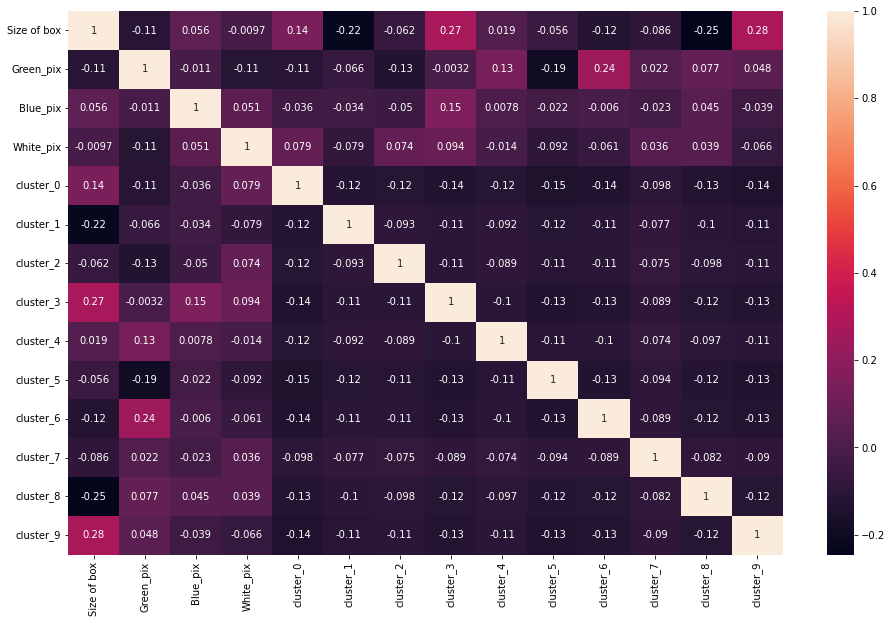

In [56]:
correlations = df_model_final.copy()

correlations.drop('Image number', axis=1, inplace=True)
correlations.drop('Win ratio', axis=1, inplace=True)

corrMatrix = correlations.corr()

plt.figure(figsize = (16,10))
sns.heatmap(corrMatrix, annot=True);

In [57]:
def correlate_features(features_to_correlate):
    for col in features_to_correlate:
        for col2 in features_to_correlate:
            if(col != col2):
                corr_name = 'Corr_' + col + '_' + col2
                df_model_final[corr_name] = df_model_final[col]*df_model_final[col2]

In [58]:
features_to_correlate = []
# features_to_correlate.append('Brightness')
# features_to_correlate.append('Green')
# features_to_correlate.append('Blue')
# features_to_correlate.append('Red')
# features_to_correlate.append('Size of box')
# features_to_correlate.append('Green_pix')
# features_to_correlate.append('Blue_pix')
# features_to_correlate.append('White_pix')

correlate_features(features_to_correlate)

### Final model

In [59]:
df_model_final.describe()

,Image number,Win ratio,Size of box,Green_pix,Blue_pix,White_pix,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9
count,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000
mean,228.500000,0.500151,0.064107,568.065502,1473.554585,21922.237991,0.133188,0.087336,0.082969,0.111354,0.080786,0.124454,0.111354,0.058952,0.096070,0.113537
std,132.357471,0.195314,0.068860,794.844108,3977.164938,15165.923447,0.340149,0.282636,0.276138,0.314914,0.272804,0.330460,0.314914,0.235792,0.295009,0.317595
min,0.000000,0.015873,0.000000,4.000000,4.000000,1026.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,114.250000,0.338524,0.006792,109.500000,156.500000,11219.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,228.500000,0.508484,0.041458,300.000000,360.000000,18300.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,342.750000,0.650534,0.099104,700.750000,896.500000,29083.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,457.000000,0.916667,0.360564,7168.000000,33592.000000,132716.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


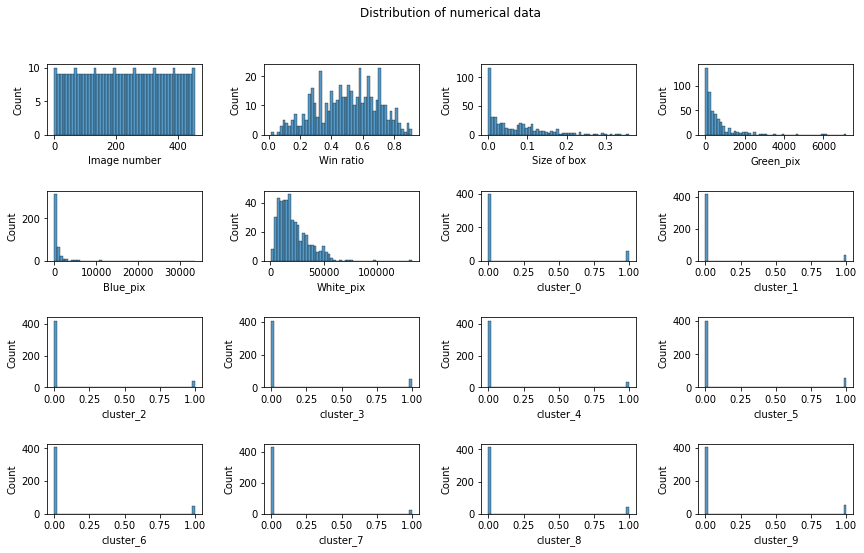

In [60]:
# plots distribution
fig = plt.figure(figsize=(14,10))

for i in range(df_model_final.columns.shape[0]):
    col = df_model_final.iloc[:,i]
    ax = plt.subplot(5, 4 ,i+1)
    sns.histplot(col, stat="count",ax = ax, bins = 50)
    
# set the spacing between subplots
plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, 
                    top=0.9, wspace=0.4, hspace=0.8)

fig.suptitle("Distribution of numerical data")

plt.show()

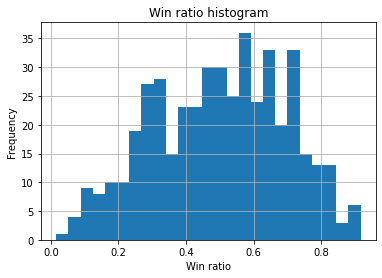

In [61]:
df_model_final['Win ratio'].hist(bins=25)
plt.title('Win ratio histogram')
plt.xlabel('Win ratio')
plt.ylabel('Frequency')
plt.show()

## Projecting in 2D (PCA)

In [62]:
from sklearn.preprocessing   import StandardScaler
from sklearn.preprocessing   import PolynomialFeatures
from sklearn.decomposition   import PCA

In [63]:
# Select target variable into an ARRAY called `y` and features into a DATAFRAME called  `X` 
y = np.array(df_model_final['Win ratio'])
features = list(set(list(df_model_final.columns)) - set(['Win ratio']))
X = df_model_final.loc[:, features]
#X

In [64]:
scaler = StandardScaler()
X_stand = scaler.fit_transform(X)

pca2 = PCA(n_components=2)
pca2.fit(X_stand)
X_proj = pca2.transform(X_stand)

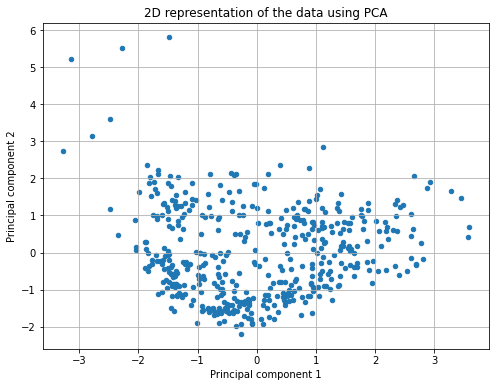

In [65]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (8, 6))
plt.scatter(X_proj[:,0], X_proj[:, 1], s = 20)
plt.title("2D representation of the data using PCA")
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")
plt.grid()
plt.show()

In [66]:
pca2.explained_variance_ratio_

array([0.11249851, 0.09708526])

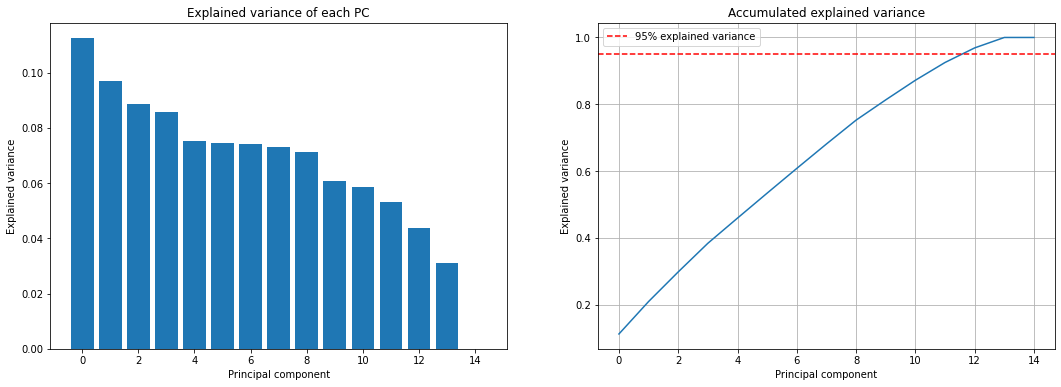

In [67]:
_, cols = X_stand.shape

pca = PCA(n_components = cols)
X_new = pca.fit_transform(X_stand)
exp_var = pca.explained_variance_ratio_

x = range(len(exp_var))
sum_exp_var = np.zeros((len(exp_var),1))
prev = 0
for i in x:
    sum_exp_var[i] = prev+exp_var[i]
    prev = sum_exp_var[i]
    
fig, ax = plt.subplots(figsize = (18,6))
plt.subplot(1,2,1)
plt.bar(x, exp_var)
plt.title('Explained variance of each PC')
plt.xlabel('Principal component')
plt.ylabel('Explained variance')
plt.subplot(1,2,2)
plt.plot(x, sum_exp_var)
plt.title('Accumulated explained variance')
plt.xlabel('Principal component')
plt.ylabel('Explained variance')
plt.grid()
plt.axhline(y=0.95, color = 'red', linestyle = '--', label = "95% explained variance")
plt.legend()
plt.show()

## Build a Model

In [68]:
import os
import math
import random
import itertools

import numpy as np    
import pandas as pd

import matplotlib 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import seaborn as sns
sns.set(style="white")

from math import log

from sklearn.dummy           import DummyClassifier
from sklearn.linear_model    import LinearRegression
from sklearn.linear_model    import LogisticRegression
from sklearn.linear_model    import Lasso
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.svm             import SVC
from sklearn.svm             import SVR
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier

from sklearn.metrics         import confusion_matrix
from sklearn.metrics         import roc_curve
from sklearn.metrics         import roc_auc_score
from sklearn.metrics         import accuracy_score
from sklearn.metrics         import mean_squared_error
from sklearn.metrics         import r2_score
from sklearn.metrics         import classification_report

from sklearn.pipeline        import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore') # ignore some warnings 

SEED = 123456789   # Define a random seed so random steps can be replicated. 

In [69]:
# df_model_final = df_model_final[:457]
df_model_final = df_model_final.dropna()

In [70]:
# Select target variable into an ARRAY called `y` and features into a DATAFRAME called  `X` 
y = np.array(df_model_final['Win ratio'])
features = list(set(list(df_model_final.columns)) - set(['Win ratio']))
X = df_model_final.loc[:, features]

In [71]:
# Divide data into a training set and a testing set using the train_test_split() function
#   NOTE: Please call the subsamples `X_train` ,  `X_test` , `y_train` , `y_test` so we can follow your code
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED)

In [72]:
def rss(y, y_hat):
    return sum( [ (yi - yi_hat)**2  for yi, yi_hat in zip(y, y_hat)] )

def mse(y, y_hat, p=0):
    return math.sqrt( (rss(y, y_hat))/ (len(y)-p-1) )

# Predicting the appeal of images

## Regression models

### Baseline

In [73]:
y_pred = [np.mean(y_train)]*len(y_test)
print("Average appeal is", np.round(np.mean(y_train), decimals = 4))

Average appeal is 0.5024


In [74]:
mse_baseline = mse(y_test, y_pred)
print("Baseline mean square error:", round(mse(y_test, y_pred), 4))

Baseline mean square error: 0.1798


In [75]:
# plt.plot(y_pred,y_test, linestyle='', marker='o', markersize=3)
# sns.kdeplot(y_pred,y_test, cmap="Reds", shade=True)
# plt.plot([0,1],[0,1])
# plt.xlim([0,1])
# plt.ylim([0,1])
# plt.title('Baseline model')
# plt.xlabel('Appeal predictions')
# plt.ylabel('Real appeal')
# plt.show()

### Linear Model with Lasso

In [76]:
estimators = []
estimators.append(('standardize', StandardScaler()))         # tell pipeline to standardize features
estimators.append(('ols_model_l1', Lasso()))                 # tell pipeline to use a linear model with lasso
pipeline_lasso = Pipeline(estimators) 

In [77]:
pipeline_lasso.get_params()

{'memory': None,
 'steps': [('standardize', StandardScaler()), ('ols_model_l1', Lasso())],
 'verbose': False,
 'standardize': StandardScaler(),
 'ols_model_l1': Lasso(),
 'standardize__copy': True,
 'standardize__with_mean': True,
 'standardize__with_std': True,
 'ols_model_l1__alpha': 1.0,
 'ols_model_l1__copy_X': True,
 'ols_model_l1__fit_intercept': True,
 'ols_model_l1__max_iter': 1000,
 'ols_model_l1__normalize': 'deprecated',
 'ols_model_l1__positive': False,
 'ols_model_l1__precompute': False,
 'ols_model_l1__random_state': None,
 'ols_model_l1__selection': 'cyclic',
 'ols_model_l1__tol': 0.0001,
 'ols_model_l1__warm_start': False}

In [78]:
###Linear model with LASSO###
x_train = np.array(X_train)
x_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

lam_range = np.logspace(-7,3,30)

splits_num = 5

MSE = np.zeros((splits_num, len(lam_range)))

for i in range(len(lam_range)):

    kf = KFold(n_splits=splits_num)

    k = 0
    for learn_index, val_index in kf.split(x_train):
        x_train_train, x_train_val = x_train[learn_index], x_train[val_index]
        y_train_train, y_train_val = y_train[learn_index], y_train[val_index]

        pipeline_lasso.set_params(ols_model_l1__alpha = lam_range[i])
        pipeline_lasso.fit(x_train_train, y_train_train)
        y_pred_lasso_proba = pipeline_lasso.predict(x_train_val)

        MSE[k, i] = round(mse(y_train_val, y_pred_lasso_proba), 4)

        k = k+1

mse_mean = np.zeros(len(lam_range))
mse_std = np.zeros(len(lam_range))
for i in range(len(lam_range)):
    mse_mean[i] = MSE[:, i].mean()
    mse_std[i] = MSE[:, i].std()
    
MSE_df = pd.DataFrame(lam_range.reshape(-1,1), columns = ["lambda"])
MSE_df["MSE-mean"] = mse_mean[:]
MSE_df["MSE-std"] = mse_std[:]
display(MSE_df)

,lambda,MSE-mean,MSE-std
0,1.000000e-07,0.18446,0.017357
1,2.212216e-07,0.18446,0.017357
2,4.893901e-07,0.18446,0.017357
3,1.082637e-06,0.18446,0.017357
4,2.395027e-06,0.18446,0.017357
5,5.298317e-06,0.18446,0.017357
6,1.172102e-05,0.18446,0.017357
7,2.592944e-05,0.18446,0.017357
8,5.736153e-05,0.18442,0.017317
9,1.268961e-04,0.18440,0.017314


In [79]:
# plt.plot(MSE_df['lambda'],MSE_df['MSE-mean'],label='MSE-mean')
# plt.fill_between(MSE_df['lambda'], MSE_df['MSE-mean']-MSE_df['MSE-std'],
#                  MSE_df['MSE-mean']+MSE_df['MSE-std'],'b', alpha=0.4, label='MSE +/- 1 STD')
# plt.xscale('log')
# plt.title('Hyperparameter tuning')
# plt.xlabel('lambda')
# plt.ylabel('Cross-val. MSE')
# plt.legend(loc='upper left')
# plt.show()

In [80]:
lambda_opt = 0.00013 # MSE is 0.15334

### SVR

In [81]:
###Support Vector Regression###

estimators = []
estimators.append(('standardize', StandardScaler()))         # tell pipeline to standardize features
estimators.append(('svm_model', SVR()))  # tell pipeline to use an SVR model with lasso
pipeline_svr = Pipeline(estimators) 
pipeline_svr.get_params()

{'memory': None,
 'steps': [('standardize', StandardScaler()), ('svm_model', SVR())],
 'verbose': False,
 'standardize': StandardScaler(),
 'svm_model': SVR(),
 'standardize__copy': True,
 'standardize__with_mean': True,
 'standardize__with_std': True,
 'svm_model__C': 1.0,
 'svm_model__cache_size': 200,
 'svm_model__coef0': 0.0,
 'svm_model__degree': 3,
 'svm_model__epsilon': 0.1,
 'svm_model__gamma': 'scale',
 'svm_model__kernel': 'rbf',
 'svm_model__max_iter': -1,
 'svm_model__shrinking': True,
 'svm_model__tol': 0.001,
 'svm_model__verbose': False}

In [82]:
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED)

c_range = np.logspace(-7,3,30)
mse_mean = np.zeros(len(c_range))

for i in range(len(c_range)):
    pipeline_svr.set_params(svm_model__C = c_range[i])
    pipeline_svr.fit(X_train_train, y_train_train)
    y_pred_svr = pipeline_svr.predict(X_train_val)
    mse_mean[i] = round(mse(y_train_val, y_pred_svr), 4)
                    
mse_df = pd.DataFrame(c_range.reshape(-1,1), columns = ["C"])
mse_df["MSE-mean"] = mse_mean[:]
display(mse_df)

,C,MSE-mean
0,1.000000e-07,0.1927
1,2.212216e-07,0.1927
2,4.893901e-07,0.1927
3,1.082637e-06,0.1927
4,2.395027e-06,0.1927
5,5.298317e-06,0.1927
6,1.172102e-05,0.1926
7,2.592944e-05,0.1926
8,5.736153e-05,0.1926
9,1.268961e-04,0.1924


In [83]:
# plt.plot(mse_df['C'],mse_df['MSE-mean'], label='MSE-mean')
# plt.fill_between(mse_df['C'], mse_df['MSE-mean']-mse_df['MSE-std'],
#                  mse_df['MSE-mean']+mse_df['MSE-std'],'b', alpha=0.4, label='MSE +/- 1 STD')
# plt.xscale('log')
# plt.title('Hyperparameter tuning')
# plt.xlabel('c')
# plt.ylabel('MSE')
# plt.legend(loc='upper left')
# plt.show()

In [84]:
c_opt = 0.07 # MSE is 0.1396

### Comparing models
Both regularised models reach very similar performances in terms of mean square error. However, the LinReg performs slightly better. This better performance is still present on the test set.

### Test score

#### Linear Regression model

In [85]:
pipeline_lasso.set_params(ols_model_l1__alpha = lambda_opt)
pipeline_lasso.fit(X_train, y_train)
y_pred_lasso = pipeline_lasso.predict(X_test)
print("Testing MSE (LASSO):", round(mse(y_test, y_pred_lasso), 4))
print("Decrease in error with respect to baseline:", np.round((mse_baseline-mse(y_test, y_pred_lasso))/mse_baseline*100, decimals = 2), "%")

Testing MSE (LASSO): 0.1652
Decrease in error with respect to baseline: 8.09 %


In [86]:
linreglasso_results = {'Predicted_val': y_pred_lasso, 'Real_val': y_test}
linreglasso_results = pd.DataFrame(linreglasso_results)
#linreglasso_results

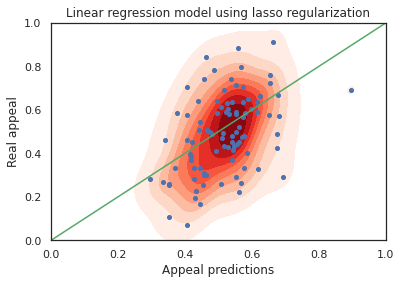

In [87]:
plt.plot(y_pred_lasso,y_test, linestyle='', marker='o', markersize=4)
sns.kdeplot(y_pred_lasso,y_test, cmap="Reds", shade=True)
plt.plot([0,1],[0,1], 'g')
plt.xlim([0,1])
plt.ylim([0,1])
plt.title('Linear regression model using lasso regularization')
plt.xlabel('Appeal predictions')
plt.ylabel('Real appeal')
plt.show()

------------------------
#### SVR model

In [88]:
pipeline_svr.set_params(svm_model__C = c_opt)
pipeline_svr.fit(X_train, y_train)
y_pred_svr = pipeline_svr.predict(X_test)
print("Testing MSE (SVR):", round(mse(y_test, y_pred_svr), 4))
print("Decrease in error with respect to baseline:", np.round((mse_baseline-mse(y_test, y_pred_svr))/mse_baseline*100, decimals = 2), "%")

Testing MSE (SVR): 0.1635
Decrease in error with respect to baseline: 9.04 %


In [89]:
svr_results = {'Predicted_val': y_pred_svr, 'Real_val': y_test}
svr_results = pd.DataFrame(svr_results)
#svr_results

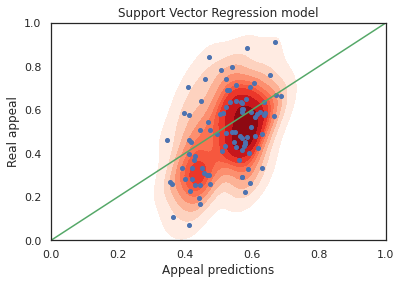

In [90]:
plt.plot(y_pred_svr,y_test, linestyle='', marker='o', markersize=4)
sns.kdeplot(y_pred_svr,y_test, cmap="Reds", shade=True)
plt.plot([0,1],[0,1], 'g')
plt.xlim([0,1])
plt.ylim([0,1])
plt.title('Support Vector Regression model')
plt.xlabel('Appeal predictions')
plt.ylabel('Real appeal')
plt.show()

Although more data is an easy answer to how we can improve the performance of the regressors, there are other ways to do so. One could explore feature engineering and dimensionality reduction (e.g. PCA) or feature selection through more varied types of regularisation. Another possibility would be to transform the regression problem into a multi-class classification problem where big deviations from the true value can be appropriately penalised.

## Classification models

### Dataset classes

In [91]:
df_model_final['class'] = 0
nclasses = 5

In [92]:
# Transform into classes 1 to nclasses
step = 1/nclasses
print(step)
for i in range(nclasses):
    inf = float("{:.4f}".format(i*step))
    sup = float("{:.4f}".format((i+1)*step))
    print(inf,sup)
    if (sup < 1):
        df_model_final['class'][(df_model_final['Win ratio'] >= inf) & (df_model_final['Win ratio'] < sup)] = i+1
    else :
        df_model_final['class'][(df_model_final['Win ratio'] >= inf)] = i+1    


0.2
0.0 0.2
0.2 0.4
0.4 0.6
0.6 0.8
0.8 1.0


In [93]:
df_model_final = df_model_final.drop('Win ratio', axis=1)

In [94]:
df_model_final['class'].value_counts()

3    160
4    131
2    109
1     32
5     26
Name: class, dtype: int64

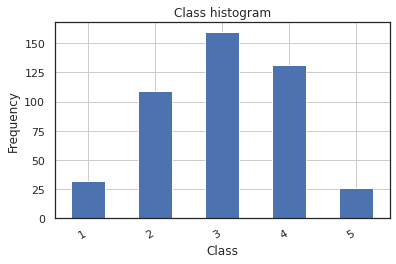

In [95]:
stars = pd.Series((1, 2, 3, 4, 5, 6))
vc = df_model_final['class'].value_counts().sort_index()
ax = vc.plot(kind='bar')
fig = ax.get_figure()
fig.autofmt_xdate()
plt.title('Class histogram')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.grid()
# plt.savefig('hist_class.png')
plt.show()

In [96]:
# Select target variable into an ARRAY called `y` and features into a DATAFRAME called  `X` 
y = np.array(df_model_final['class'])
features = list(set(list(df_model_final.columns)) - set(['class']))
X = df_model_final.loc[:, features]

In [97]:
# Divide data into a training set and a testing set using the train_test_split() function
#   NOTE: Please call the subsamples `X_train` ,  `X_test` , `y_train` , `y_test` so we can follow your code
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED)

### Baseline

In [98]:
from numpy import argmax
from tensorflow.keras.utils import to_categorical

In [99]:
# Predict the most occured outcome

In [100]:
def baseline_model(y_train, y_test):   
    y_train_df = pd.DataFrame(y_train)
    most_freq = np.argmax(y_train_df.value_counts())

    y_hat = np.array([int(np.round(y_train_df.value_counts().index[most_freq]))]*len(y_train))
    y_hat_df = pd.DataFrame((y_hat), columns = ["prediction"])
    y_hat_df["truth"] = y_train
    #y_hat_df.head()

    y_hat = [int(np.round(y_train_df.value_counts().index[most_freq]))]*len(y_test)
    cm = confusion_matrix(y_test, y_hat)
    print(y_test)
    acc =np.diagonal(cm).sum()/cm.sum()
    
    encoded_test = to_categorical(y_test, num_classes=nclasses + 1)
    encoded_hat = to_categorical(y_hat, num_classes=nclasses + 1)
    
    auc = roc_auc_score(encoded_test[:,1:], encoded_hat[:,1:], multi_class="ovr", average='macro')
    
    return y_hat_df, acc, auc

In [101]:
y_hat_df, acc_baseline, auc_baseline = baseline_model(y_train, y_test)
y_hat_df.head()

[2 3 4 4 2 3 2 3 4 4 3 3 3 2 4 3 2 3 2 3 3 2 2 2 3 1 4 2 4 4 3 4 2 3 3 2 4
 3 2 1 3 1 2 2 4 5 3 4 2 3 3 2 3 2 4 2 4 3 3 2 3 3 3 4 3 3 4 2 4 4 3 3 4 4
 3 4 3 3 2 2 3 4 2 3 3 3 1 4 5 3 5 3]


,prediction,truth
0,3,4
1,3,2
2,3,4
3,3,1
4,3,4


In [102]:
auc_baseline

0.5

### Linear OLS model

The first model we will try is a linear regression coupled with LASSO regularisation. We will determine the optimal  𝜆  (LASSO hypereparameter) which maximises the AUC score of the model. In our first approach, we will not apply any kind of PCA.

In [103]:
def ols_lasso_CV(x_train, y_train, lam_range):
    splits_num = 5

    AUC = np.zeros((splits_num, len(lam_range)))

    for i in range(len(lam_range)):

        kf = KFold(n_splits=splits_num)

        k = 0
        for learn_index, val_index in kf.split(x_train):
            x_train_train, x_train_val = x_train[learn_index], x_train[val_index]
            y_train_train, y_train_val = y_train[learn_index], y_train[val_index]

            pipeline_lasso.set_params(ols_model_l1__alpha = lam_range[i])
            pipeline_lasso.fit(x_train_train, y_train_train)
            y_pred_lasso_proba = pipeline_lasso.predict(x_train_val)
            
            encoded_y_train_val = to_categorical(y_train_val, num_classes=nclasses + 1)

            '''ERROR HERE'''
            max_y_pred = (nclasses + 1)/10 - 0.1
            y_pred_lasso_proba = np.clip(y_pred_lasso_proba,0,max_y_pred) #doing this fix it, not sure that's good
            encoded_y_pred_lasso_proba = to_categorical(y_pred_lasso_proba, num_classes=nclasses + 1)
            '''ERROR HERE'''

            
            AUC[k, i] = round(roc_auc_score(encoded_y_train_val[:,1:], encoded_y_pred_lasso_proba[:,1:],
                                            multi_class="ovr", average='micro'), 4)

            k = k+1

    auc_mean = np.zeros(len(lam_range))
    auc_std = np.zeros(len(lam_range))
    for i in range(len(lam_range)):
        auc_mean[i] = AUC[:, i].mean()
        auc_std[i] = AUC[:, i].std()
        
    return auc_mean, auc_std

In [104]:
estimators = []
estimators.append(('standardize', StandardScaler()))         # tell pipeline to standardize features
estimators.append(('ols_model_l1', Lasso()))                 # tell pipeline to use a linear model with lasso
pipeline_lasso = Pipeline(estimators) 

In [105]:
pipeline_lasso.get_params()

{'memory': None,
 'steps': [('standardize', StandardScaler()), ('ols_model_l1', Lasso())],
 'verbose': False,
 'standardize': StandardScaler(),
 'ols_model_l1': Lasso(),
 'standardize__copy': True,
 'standardize__with_mean': True,
 'standardize__with_std': True,
 'ols_model_l1__alpha': 1.0,
 'ols_model_l1__copy_X': True,
 'ols_model_l1__fit_intercept': True,
 'ols_model_l1__max_iter': 1000,
 'ols_model_l1__normalize': 'deprecated',
 'ols_model_l1__positive': False,
 'ols_model_l1__precompute': False,
 'ols_model_l1__random_state': None,
 'ols_model_l1__selection': 'cyclic',
 'ols_model_l1__tol': 0.0001,
 'ols_model_l1__warm_start': False}

In [106]:
x_train = np.array(X_train)
x_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

lam_range = np.logspace(-7,3,30)

auc_mean, auc_std = ols_lasso_CV(x_train, y_train, lam_range)

In [107]:
auc_df = pd.DataFrame(lam_range.reshape(-1,1), columns = ["Lambda"])
auc_df["AUC-mean"] = auc_mean[:]
auc_df["AUC-std"] = auc_std[:]
display(auc_df)

,Lambda,AUC-mean,AUC-std
0,1.000000e-07,0.5,0.0
1,2.212216e-07,0.5,0.0
2,4.893901e-07,0.5,0.0
3,1.082637e-06,0.5,0.0
4,2.395027e-06,0.5,0.0
5,5.298317e-06,0.5,0.0
6,1.172102e-05,0.5,0.0
7,2.592944e-05,0.5,0.0
8,5.736153e-05,0.5,0.0
9,1.268961e-04,0.5,0.0


In [108]:
# lambda_ols_class = 0.0001
# auc_linear = 0.63132

### Logit model

We now try a logit model with LASSO regularisation and optimise for the C parameter of the regularisation. We approach the problem in the same way as for the previous model.

In [109]:
def logit_CV(x_train, y_train, c_range):
    splits_num = 5

    AUC = np.zeros((splits_num, len(c_range)))

    for i in range(len(c_range)):

        kf = KFold(n_splits=splits_num)

        k = 0
        for learn_index, val_index in kf.split(x_train):
            x_train_train, x_train_val = x_train[learn_index], x_train[val_index]
            y_train_train, y_train_val = y_train[learn_index], y_train[val_index]

            pipeline_logit.set_params(logit_model_l1__C = c_range[i])

            pipeline_logit.fit(x_train_train, y_train_train)

            y_pred_logit_proba = pipeline_logit.predict(x_train_val)
            
            encoded_y_train_val = to_categorical(y_train_val, num_classes=nclasses + 1)
            encoded_y_pred_logit_proba = to_categorical(y_pred_logit_proba, num_classes=nclasses + 1)

            AUC[k, i] = round(roc_auc_score(encoded_y_train_val[:,1:], encoded_y_pred_logit_proba[:,1:],
                                            multi_class="ovr", average='micro'), 4)

            k = k+1

    auc_mean = np.zeros(len(c_range))
    auc_std = np.zeros(len(c_range))
    for i in range(len(c_range)):
        auc_mean[i] = AUC[:, i].mean()
        auc_std[i] = AUC[:, i].std()
        
    return auc_mean, auc_std

In [110]:
estimators = []
estimators.append(('standardize', StandardScaler()))         # tell pipeline to standardize features
estimators.append(('logit_model_l1', LogisticRegression(penalty = "l1", solver = "saga", random_state = SEED)))  # tell pipeline to use a logit model with lasso
pipeline_logit = Pipeline(estimators) 
pipeline_logit.get_params()

{'memory': None,
 'steps': [('standardize', StandardScaler()),
  ('logit_model_l1',
   LogisticRegression(penalty='l1', random_state=123456789, solver='saga'))],
 'verbose': False,
 'standardize': StandardScaler(),
 'logit_model_l1': LogisticRegression(penalty='l1', random_state=123456789, solver='saga'),
 'standardize__copy': True,
 'standardize__with_mean': True,
 'standardize__with_std': True,
 'logit_model_l1__C': 1.0,
 'logit_model_l1__class_weight': None,
 'logit_model_l1__dual': False,
 'logit_model_l1__fit_intercept': True,
 'logit_model_l1__intercept_scaling': 1,
 'logit_model_l1__l1_ratio': None,
 'logit_model_l1__max_iter': 100,
 'logit_model_l1__multi_class': 'auto',
 'logit_model_l1__n_jobs': None,
 'logit_model_l1__penalty': 'l1',
 'logit_model_l1__random_state': 123456789,
 'logit_model_l1__solver': 'saga',
 'logit_model_l1__tol': 0.0001,
 'logit_model_l1__verbose': 0,
 'logit_model_l1__warm_start': False}

In [111]:
c_range = np.logspace(-3,6,30)

auc_mean, auc_std = logit_CV(x_train, y_train, c_range)
    
auc_df = pd.DataFrame(c_range.reshape(-1,1), columns = ["C"])
auc_df["AUC-mean"] = auc_mean[:]
auc_df["AUC-std"] = auc_std[:]
display(auc_df)

,C,AUC-mean,AUC-std
0,0.001000,0.54400,0.018344
1,0.002043,0.58338,0.032528
2,0.004175,0.58338,0.032528
3,0.008532,0.58338,0.032528
4,0.017433,0.58338,0.032528
5,0.035622,0.58852,0.032312
6,0.072790,0.60380,0.009395
7,0.148735,0.63466,0.041306
8,0.303920,0.62780,0.030102
9,0.621017,0.62442,0.029450


In [112]:
# c_logit_class = 1
# auc_logit = 0.64482

### SVM model

In [113]:
estimators = []
estimators.append(('standardize', StandardScaler()))         # tell pipeline to standardize features
estimators.append(('svm_model', SVC(probability = True, random_state = SEED)))  # tell pipeline to use a logit model with lasso
pipeline_svc = Pipeline(estimators) 
pipeline_svc.get_params()

{'memory': None,
 'steps': [('standardize', StandardScaler()),
  ('svm_model', SVC(probability=True, random_state=123456789))],
 'verbose': False,
 'standardize': StandardScaler(),
 'svm_model': SVC(probability=True, random_state=123456789),
 'standardize__copy': True,
 'standardize__with_mean': True,
 'standardize__with_std': True,
 'svm_model__C': 1.0,
 'svm_model__break_ties': False,
 'svm_model__cache_size': 200,
 'svm_model__class_weight': None,
 'svm_model__coef0': 0.0,
 'svm_model__decision_function_shape': 'ovr',
 'svm_model__degree': 3,
 'svm_model__gamma': 'scale',
 'svm_model__kernel': 'rbf',
 'svm_model__max_iter': -1,
 'svm_model__probability': True,
 'svm_model__random_state': 123456789,
 'svm_model__shrinking': True,
 'svm_model__tol': 0.001,
 'svm_model__verbose': False}

For the SVM classifier, 5-fold cross-validation is included in the sklearn command.

In [114]:
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=SEED)

In [115]:
c_range = np.logspace(-3,6,30)
auc_mean = np.zeros(len(c_range))

for i in range(len(c_range)):
    pipeline_svc.set_params(svm_model__C = c_range[i])
    pipeline_svc.fit(X_train_train, y_train_train)
    y_pred_svc_proba = pipeline_svc.predict(X_train_val)
    encoded_y_train_val = to_categorical(y_train_val, num_classes=nclasses + 1)
    encoded_y_pred_svm_proba = to_categorical(y_pred_svc_proba, num_classes=nclasses + 1)
    auc_mean[i] = round(roc_auc_score(encoded_y_train_val[:,1:], encoded_y_pred_svm_proba[:,1:], 
                                      multi_class="ovr", average='micro'), 4)
                    
auc_df = pd.DataFrame(c_range.reshape(-1,1), columns = ["C"])
auc_df["AUC"] = auc_mean[:]
display(auc_df)

,C,AUC
0,0.001000,0.5856
1,0.002043,0.5856
2,0.004175,0.5856
3,0.008532,0.5856
4,0.017433,0.5856
5,0.035622,0.5856
6,0.072790,0.5856
7,0.148735,0.5856
8,0.303920,0.6196
9,0.621017,0.6196


In [116]:
# c_svm_class = 10
# auc_svm = 0.6128

### KNN

In [117]:
def knn_CV(x_train, y_train, n_neighb):
    splits_num = 5

    AUC = np.zeros((splits_num, len(n_neighb)))

    for i in range(len(n_neighb)):

        kf = KFold(n_splits=splits_num)

        k = 0
        for learn_index, val_index in kf.split(x_train):
            x_train_train, x_train_val = x_train[learn_index], x_train[val_index]
            y_train_train, y_train_val = y_train[learn_index], y_train[val_index]

            pipeline_knn.set_params(knn_model__n_neighbors = n_neighb[i])

            pipeline_knn.fit(x_train_train, y_train_train)

            y_pred_knn_proba = pipeline_knn.predict(x_train_val)
            
            encoded_y_train_val = to_categorical(y_train_val, num_classes=nclasses + 1)
            encoded_y_pred_knn_proba = to_categorical(y_pred_knn_proba, num_classes=nclasses + 1)

            AUC[k, i] = round(roc_auc_score(encoded_y_train_val[:,1:], encoded_y_pred_knn_proba[:,1:],
                                            multi_class="ovr", average='micro'), 4)

            k = k+1

    auc_mean = np.zeros(len(n_neighb))
    auc_std = np.zeros(len(n_neighb))
    for i in range(len(n_neighb)):
        auc_mean[i] = AUC[:, i].mean()
        auc_std[i] = AUC[:, i].std()
        
    return auc_mean, auc_std

In [118]:
estimators = []
estimators.append(('standardize', StandardScaler()))         # tell pipeline to standardize features
estimators.append(('knn_model',KNeighborsClassifier()))  # tell pipeline to use a logit model with lasso
pipeline_knn = Pipeline(estimators) 
pipeline_knn.get_params()

{'memory': None,
 'steps': [('standardize', StandardScaler()),
  ('knn_model', KNeighborsClassifier())],
 'verbose': False,
 'standardize': StandardScaler(),
 'knn_model': KNeighborsClassifier(),
 'standardize__copy': True,
 'standardize__with_mean': True,
 'standardize__with_std': True,
 'knn_model__algorithm': 'auto',
 'knn_model__leaf_size': 30,
 'knn_model__metric': 'minkowski',
 'knn_model__metric_params': None,
 'knn_model__n_jobs': None,
 'knn_model__n_neighbors': 5,
 'knn_model__p': 2,
 'knn_model__weights': 'uniform'}

In [119]:
n_neighb = np.arange(2, 15, 1)

auc_mean, auc_std = knn_CV(x_train, y_train, n_neighb)
    
auc_df = pd.DataFrame(n_neighb.reshape(-1,1), columns = ["N"])
auc_df["AUC-mean"] = auc_mean[:]
auc_df["AUC-std"] = auc_std[:]
display(auc_df)

,N,AUC-mean,AUC-std
0,2,0.54404,0.036377
1,3,0.56116,0.024017
2,4,0.56794,0.022472
3,5,0.55092,0.022847
4,6,0.57500,0.046042
5,7,0.58000,0.025916
6,8,0.58856,0.031273
7,9,0.59200,0.027539
8,10,0.57998,0.020871
9,11,0.59018,0.025283


In [120]:
# n_knn_class = 5
# auc_knn = 0.60548

### Decision trees

In [121]:
def dtc_CV(x_train, y_train, d_depth):
    splits_num = 5

    AUC = np.zeros((splits_num, len(d_depth)))

    for i in range(len(d_depth)):

        kf = KFold(n_splits=splits_num)

        k = 0
        for learn_index, val_index in kf.split(x_train):
            x_train_train, x_train_val = x_train[learn_index], x_train[val_index]
            y_train_train, y_train_val = y_train[learn_index], y_train[val_index]

            pipeline_dtc.set_params(dtc_model__max_depth = d_depth[i])

            pipeline_dtc.fit(x_train_train, y_train_train)

            y_pred_dtc_proba = pipeline_dtc.predict(x_train_val)
            
            encoded_y_train_val = to_categorical(y_train_val, num_classes=nclasses + 1)
            encoded_y_pred_dtc_proba = to_categorical(y_pred_dtc_proba, num_classes=nclasses + 1)

            AUC[k, i] = round(roc_auc_score(encoded_y_train_val[:,1:], encoded_y_pred_dtc_proba[:,1:],
                                            multi_class="ovr", average='micro'), 4)

            k = k+1

    auc_mean = np.zeros(len(d_depth))
    auc_std = np.zeros(len(d_depth))
    for i in range(len(d_depth)):
        auc_mean[i] = AUC[:, i].mean()
        auc_std[i] = AUC[:, i].std()
        
    return auc_mean, auc_std

In [122]:
estimators = []
estimators.append(('standardize', StandardScaler()))         # tell pipeline to standardize features
estimators.append(('dtc_model',DecisionTreeClassifier(random_state = SEED)))  # tell pipeline to use a logit model with lasso
pipeline_dtc = Pipeline(estimators) 
pipeline_dtc.get_params()

{'memory': None,
 'steps': [('standardize', StandardScaler()),
  ('dtc_model', DecisionTreeClassifier(random_state=123456789))],
 'verbose': False,
 'standardize': StandardScaler(),
 'dtc_model': DecisionTreeClassifier(random_state=123456789),
 'standardize__copy': True,
 'standardize__with_mean': True,
 'standardize__with_std': True,
 'dtc_model__ccp_alpha': 0.0,
 'dtc_model__class_weight': None,
 'dtc_model__criterion': 'gini',
 'dtc_model__max_depth': None,
 'dtc_model__max_features': None,
 'dtc_model__max_leaf_nodes': None,
 'dtc_model__min_impurity_decrease': 0.0,
 'dtc_model__min_samples_leaf': 1,
 'dtc_model__min_samples_split': 2,
 'dtc_model__min_weight_fraction_leaf': 0.0,
 'dtc_model__random_state': 123456789,
 'dtc_model__splitter': 'best'}

In [123]:
d_depth = np.arange(2, 15, 1)

auc_mean, auc_std = dtc_CV(x_train, y_train, d_depth)
    
auc_df = pd.DataFrame(d_depth.reshape(-1,1), columns = ["D"])
auc_df["AUC-mean"] = auc_mean[:]
auc_df["AUC-std"] = auc_std[:]
display(auc_df)

,D,AUC-mean,AUC-std
0,2,0.60214,0.012344
1,3,0.61412,0.024661
2,4,0.60904,0.024674
3,5,0.60556,0.019830
4,6,0.59020,0.035850
5,7,0.59190,0.013359
6,8,0.59022,0.019614
7,9,0.59010,0.025055
8,10,0.57814,0.013555
9,11,0.58322,0.023512


In [124]:
# d_dtc_class = 2
# auc_dtc = 0.61058

### Random Forest

In [125]:
def randfor_CV(x_train, y_train, f_depth):
    splits_num = 5

    AUC = np.zeros((splits_num, len(f_depth)))

    for i in range(len(f_depth)):

        kf = KFold(n_splits=splits_num)

        k = 0
        for learn_index, val_index in kf.split(x_train):
            x_train_train, x_train_val = x_train[learn_index], x_train[val_index]
            y_train_train, y_train_val = y_train[learn_index], y_train[val_index]

            pipeline_randfor.set_params(dtc_model__max_depth = d_depth[i])

            pipeline_randfor.fit(x_train_train, y_train_train)

            y_pred_randfor_proba = pipeline_randfor.predict(x_train_val)
            
            encoded_y_train_val = to_categorical(y_train_val, num_classes=nclasses + 1)
            encoded_y_pred_randfor_proba = to_categorical(y_pred_randfor_proba, num_classes=nclasses + 1)

            AUC[k, i] = round(roc_auc_score(encoded_y_train_val[:,1:], encoded_y_pred_randfor_proba[:,1:],
                                            multi_class="ovr", average='micro'), 4)

            k = k+1

    auc_mean = np.zeros(len(f_depth))
    auc_std = np.zeros(len(f_depth))
    for i in range(len(f_depth)):
        auc_mean[i] = AUC[:, i].mean()
        auc_std[i] = AUC[:, i].std()
        
    return auc_mean, auc_std

In [126]:
estimators = []
estimators.append(('standardize', StandardScaler()))         # tell pipeline to standardize features
estimators.append(('randfor_model',RandomForestClassifier(random_state = SEED)))  # tell pipeline to use a logit model with lasso
pipeline_randfor = Pipeline(estimators) 
pipeline_randfor.get_params()

{'memory': None,
 'steps': [('standardize', StandardScaler()),
  ('randfor_model', RandomForestClassifier(random_state=123456789))],
 'verbose': False,
 'standardize': StandardScaler(),
 'randfor_model': RandomForestClassifier(random_state=123456789),
 'standardize__copy': True,
 'standardize__with_mean': True,
 'standardize__with_std': True,
 'randfor_model__bootstrap': True,
 'randfor_model__ccp_alpha': 0.0,
 'randfor_model__class_weight': None,
 'randfor_model__criterion': 'gini',
 'randfor_model__max_depth': None,
 'randfor_model__max_features': 'auto',
 'randfor_model__max_leaf_nodes': None,
 'randfor_model__max_samples': None,
 'randfor_model__min_impurity_decrease': 0.0,
 'randfor_model__min_samples_leaf': 1,
 'randfor_model__min_samples_split': 2,
 'randfor_model__min_weight_fraction_leaf': 0.0,
 'randfor_model__n_estimators': 100,
 'randfor_model__n_jobs': None,
 'randfor_model__oob_score': False,
 'randfor_model__random_state': 123456789,
 'randfor_model__verbose': 0,
 'randf

In [127]:
# f_depth = np.arange(2, 15, 1)

# auc_mean, auc_std = randfor_CV(x_train, y_train, f_depth)
    
# auc_df = pd.DataFrame(f_depth.reshape(-1,1), columns = ["F"])
# auc_df["AUC-mean"] = auc_mean[:]
# auc_df["AUC-std"] = auc_std[:]
# display(auc_df)

In [128]:
# f_randfor_class = 3
# auc_randfor = 0.61058

### Test AUC

We finally test our models on unforeseen data and compute the AUC. The logit model performs better and obtains a higher AUC score. If we wanted to compare the models even more thoroughly we could have performed a form of nested cross-validation where inner folds are used to optimise hyperparameters while outer folds allow to select the best model.

In [129]:
print("Test AUC (baseline):", auc_baseline)

lambda_ols_class=0.1
pipeline_lasso.set_params(ols_model_l1__alpha = lambda_ols_class)
pipeline_lasso.fit(X_train, y_train)
y_pred_lasso_proba = pipeline_lasso.predict(X_test)
encoded_y_test = to_categorical(y_test, num_classes=nclasses + 1)
encoded_y_pred_lasso_proba = to_categorical(y_pred_lasso_proba, num_classes=nclasses + 1)
print("Test AUC (LASSO):", roc_auc_score(encoded_y_test[:,1:], encoded_y_pred_lasso_proba[:,1:],
                                         multi_class="ovr", average='micro'))


c_logit_class=10
pipeline_logit.set_params(logit_model_l1__C = c_logit_class)
pipeline_logit.fit(X_train, y_train)
y_pred_logit_proba = pipeline_logit.predict(X_test)
encoded_y_test = to_categorical(y_test, num_classes=nclasses + 1)
encoded_y_pred_logit_proba = to_categorical(y_pred_logit_proba, num_classes=nclasses + 1)
print("Test AUC (logit):", roc_auc_score(encoded_y_test[:,1:], encoded_y_pred_logit_proba[:,1:],
                                         multi_class="ovr", average='micro'))  

c_svm_class=0.001                                         
pipeline_svc.set_params(svm_model__C = c_svm_class)
pipeline_svc.fit(X_train, y_train)
y_pred_svc_proba = pipeline_svc.predict(X_test)
encoded_y_test = to_categorical(y_test, num_classes=nclasses + 1)
encoded_y_pred_svc_proba = to_categorical(y_pred_svc_proba, num_classes=nclasses + 1)
print("Test AUC (SVM):", roc_auc_score(encoded_y_test[:,1:], encoded_y_pred_svc_proba[:,1:],
                                         multi_class="ovr", average='micro'))

n_knn_class=11
pipeline_knn.set_params(knn_model__n_neighbors = n_knn_class)
pipeline_knn.fit(X_train, y_train)
y_pred_knn_proba = pipeline_knn.predict(X_test)
encoded_y_test = to_categorical(y_test, num_classes=nclasses + 1)
encoded_y_pred_knn_proba = to_categorical(y_pred_knn_proba, num_classes=nclasses + 1)
print("Test AUC (KNN):", roc_auc_score(encoded_y_test[:,1:], encoded_y_pred_knn_proba[:,1:],
                                         multi_class="ovr", average='micro'))

d_depth=8
pipeline_dtc.set_params(dtc_model__max_depth = d_depth)
pipeline_dtc.fit(X_train, y_train)
y_pred_dtc_proba = pipeline_dtc.predict(X_test)
encoded_y_test = to_categorical(y_test, num_classes=nclasses + 1)
encoded_y_pred_dtc_proba = to_categorical(y_pred_dtc_proba, num_classes=nclasses + 1)
print("Test AUC (Dec. Tree):", roc_auc_score(encoded_y_test[:,1:], encoded_y_pred_dtc_proba[:,1:],
                                         multi_class="ovr", average='micro'))

f_randfor_class=2
pipeline_randfor.set_params(randfor_model__max_depth = f_randfor_class)
pipeline_randfor.fit(X_train, y_train)
y_pred_randfor_proba = pipeline_randfor.predict(X_test)
encoded_y_test = to_categorical(y_test, num_classes=nclasses + 1)
encoded_y_pred_randfor_proba = to_categorical(y_pred_randfor_proba, num_classes=nclasses + 1)
print("Test AUC (Rand. For.):", roc_auc_score(encoded_y_test[:,1:], encoded_y_pred_randfor_proba[:,1:],
                                         multi_class="ovr", average='micro'))

   
                                    

Test AUC (baseline): 0.5
Test AUC (LASSO): 0.6603260869565217
Test AUC (logit): 0.6127717391304349
Test AUC (SVM): 0.6331521739130435
Test AUC (KNN): 0.6059782608695651
Test AUC (Dec. Tree): 0.578804347826087
Test AUC (Rand. For.): 0.6195652173913043


In [130]:
models_classification = pd.DataFrame([[auc_baseline], [roc_auc_score(encoded_y_test[:,1:], encoded_y_pred_lasso_proba[:,1:], multi_class="ovr", average='micro')],
                                    [roc_auc_score(encoded_y_test[:,1:], encoded_y_pred_logit_proba[:,1:], multi_class="ovr", average='micro')],
                                     [roc_auc_score(encoded_y_test[:,1:], encoded_y_pred_svc_proba[:,1:], multi_class="ovr", average='micro')],
                                     [roc_auc_score(encoded_y_test[:,1:], encoded_y_pred_knn_proba[:,1:], multi_class="ovr", average='micro')],
                                     [roc_auc_score(encoded_y_test[:,1:], encoded_y_pred_dtc_proba[:,1:], multi_class="ovr", average='micro')],
                                     [roc_auc_score(encoded_y_test[:,1:], encoded_y_pred_randfor_proba[:,1:], multi_class="ovr", average='micro')]],
                                    index=['baseline','Lasso','logit','SVM','KNN','Dec. Tree','Rand. For.'], columns=['Test AUC'])

In [131]:
models_classification

,Test AUC
baseline,0.500000
Lasso,0.660326
logit,0.612772
SVM,0.633152
KNN,0.605978
Dec. Tree,0.578804
Rand. For.,0.619565


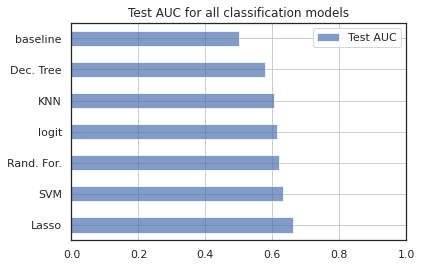

In [132]:
models_classification.sort_values(by='Test AUC', ascending=False).plot(kind='barh', alpha=0.7)
plt.title('Test AUC for all classification models')
plt.xlim(0,1)
plt.grid();

### Confusion matrix for the best classifier

In [133]:
cm_opt = confusion_matrix(y_test,y_pred_logit_proba)
cm_opt

array([[ 0,  4,  0,  0,  0],
       [ 0, 10,  7,  7,  0],
       [ 0,  9, 15, 14,  0],
       [ 0,  1, 12, 10,  0],
       [ 0,  0,  2,  1,  0]])

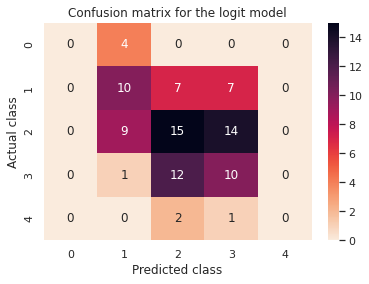

In [134]:
cmap = sns.cm.rocket_r
sns.heatmap(cm_opt, annot=True, cmap = cmap)
plt.title('Confusion matrix for the logit model')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
# plt.savefig('CM_bestmodel.png')
plt.show()

In [135]:
diff_target = np.abs(y_pred_logit_proba-y_test)
print('Proportion of images correctly classified', round(np.count_nonzero(diff_target == 0)/np.sum(cm_opt),4))
print('Proportion of images classified at 1 class away from the truth',
      round(np.count_nonzero(diff_target == 1)/np.sum(cm_opt),4))
print('Proportion of images classified at 2 classes away from the truth',
      round(np.count_nonzero(diff_target == 2)/np.sum(cm_opt),4))
print('Proportion of images classified at 3 classes away from the truth',
      round(np.count_nonzero(diff_target == 3)/np.sum(cm_opt),4))

Proportion of images correctly classified 0.3804
Proportion of images classified at 1 class away from the truth 0.5109
Proportion of images classified at 2 classes away from the truth 0.1087
Proportion of images classified at 3 classes away from the truth 0.0
